In [1]:
import sys
sys.path.append("EasyOCR/")

import easyocr

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import importlib
import os
from collections import OrderedDict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import torch
import yaml

from easyocr.detection import CRAFT

## CRAFT

In [4]:
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

In [5]:
model = CRAFT()

model_path = '/home/anastasia/DATA/AIArchitecture/HandWritingDescriptor/text-recognition-research/model_dir/craft_mlt_25k.pth'
model.load_state_dict(copyStateDict(torch.load(model_path, map_location="cpu", weights_only=False)))

model = model.eval()

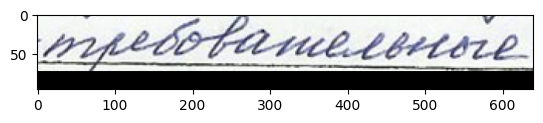

In [ ]:
image = easyocr.imgproc.loadImage('../data/cyrillic-handwriting-dataset/test/test1233.png')
img_resized, target_ratio, size_heatmap = easyocr.imgproc.resize_aspect_ratio(
    image, 640, interpolation=cv2.INTER_LINEAR, mag_ratio=1.5
)
ratio_h = ratio_w = 1 / target_ratio

x = easyocr.imgproc.normalizeMeanVariance(img_resized)
x = torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0)   # [h, w, c] to [n, c, h, w]
x.shape

In [13]:
torch.onnx.export(
    model=model,
    args=x,
    f="onnx-models/craft.onnx",
    opset_version=15,
    input_names=['input'],
    output_names=['output'],
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        'input': {0:'batch_size', 2: 'height', 3: 'width'},    # dynamic batch size
        'output': {0: 'batch_size'}
    }
)

### test

In [14]:
dummy_input = np.random.rand(4, 3, 320, 320).astype(np.float32)

In [15]:
with torch.no_grad():   
    torch_output = model(torch.from_numpy(dummy_input))
    
ort_session = ort.InferenceSession("onnx-models/craft.onnx")
onnx_output = ort_session.run(None, {'input': dummy_input})

print(torch_output[0].shape, onnx_output[0].shape)
print(torch_output[1].shape, onnx_output[1].shape)

torch.Size([4, 160, 160, 2]) (4, 160, 160, 2)
torch.Size([4, 32, 160, 160]) (4, 32, 160, 160)


In [16]:
np.testing.assert_almost_equal(torch_output[0].numpy(), onnx_output[0], decimal=4)
np.testing.assert_almost_equal(torch_output[1].numpy(), onnx_output[1], decimal=4)

In [ ]:
sess = ort.InferenceSession("onnx-models/craft.onnx") #1000x960 resize to 512x384
sess.get_inputs()[0].name, sess.get_outputs()[0].name 



('input', 'output')

In [72]:
y, feature = sess.run(None, {'input': x.numpy()})

In [73]:
# make score and link map
score_text = y[0, :, :, 0]
score_link = y[0, :, :, 1]

# refine link
#with torch.no_grad():
#    y_refiner = refine_net(y, feature)
#score_link = y_refiner[0,:,:,0].cpu().data.numpy()

boxes, polys, _ = easyocr.craft_utils.getDetBoxes(score_text, score_link, 0.7, 0.4, 0.4, True)
boxes = easyocr.craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
boxes

array([[[  8.541073 ,  -3.3401034],
        [640.6366   ,   4.528309 ],
        [639.82306  ,  69.88363  ],
        [  7.7275033,  62.01522  ]]], dtype=float32)

In [76]:
ratio_h, ratio_w

(1.003125, 1.003125)

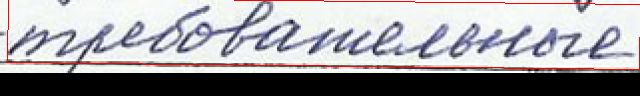

In [75]:
from PIL import Image, ImageDraw
import numpy as np

image = Image.fromarray(img_resized.astype(np.uint8))
draw = ImageDraw.Draw(image)

draw.polygon(boxes, outline=(255, 0, 0), fill=None)
image

## Recognition

In [4]:
model_dir = "/home/anastasia/DATA/AIArchitecture/HandWritingDescriptor/text-recognition-research/model_dir"
recog_network = "model_1"

In [5]:
with open(os.path.join(model_dir, recog_network + '.yaml'), encoding='utf8') as file:
    recog_config = yaml.load(file, Loader=yaml.FullLoader)

imgH = recog_config['imgH']
available_lang = recog_config['lang_list']
network_params = recog_config['network_params']
num_class = recog_config['num_class']

model_path = os.path.join(model_dir, recog_network + '.pth')

In [11]:
model_pkg = importlib.import_module("easyocr.model.vgg_model")
model = model_pkg.Model(num_class=num_class, **network_params)

In [13]:
state_dict = torch.load(model_path, map_location="cpu", weights_only=False)
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    new_key = key[7:]
    new_state_dict[new_key] = value
model.load_state_dict(new_state_dict)
model = model.eval()

In [14]:
batch_size_1_1 = 500
in_shape_1=[1, 1, 64, batch_size_1_1]
dummy_input_1 = torch.rand(in_shape_1)

batch_size_2_1 = 50
in_shape_2=[1, batch_size_2_1]
dummy_input_2 = torch.rand(in_shape_2)

dummy_input = (dummy_input_1, dummy_input_2)

torch.onnx.export(
    model,
    dummy_input,
    "onnx-models/recognitionModel.onnx",
    export_params=True,
    opset_version=15,
    input_names = ['input1','input2'],
    output_names = ['output'],
    dynamic_axes={'input1' : {3 : 'batch_size_1_1'}},
)

/home/anastasia/venvs/ai_architecture/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


### test

In [38]:
batch_size_1_1 = 300
dummy_input_1 = np.random.rand(*[1, 1, 64, batch_size_1_1]).astype(np.float32)

batch_size_2_1 = 20
dummy_input_2 = np.random.rand(*[1, batch_size_2_1]).astype(np.float32)

In [ ]:
with torch.no_grad():   
    torch_output = model(torch.from_numpy(dummy_input_1), torch.from_numpy(dummy_input_2))
    
ort_session = ort.InferenceSession("onnx-models/recognitionModel.onnx")
onnx_output = ort_session.run(None, {'input1': dummy_input_1})

torch_output.shape, onnx_output[0].shape

In [42]:
np.testing.assert_almost_equal(torch_output.numpy(), onnx_output[0], decimal=4)

## Test Detection & Recognition 

In [18]:
detector_session = ort.InferenceSession("onnx-models/craft.onnx")
recognition_session = ort.InferenceSession("onnx-models/recognitionModel.onnx")

In [20]:
image = easyocr.imgproc.loadImage('../data/cyrillic-handwriting-dataset/test/test1233.png')
img_resized, target_ratio, size_heatmap = easyocr.imgproc.resize_aspect_ratio(
    image, 640, interpolation=cv2.INTER_LINEAR, mag_ratio=1.5
)
ratio_h = ratio_w = 1 / target_ratio

detector_input = easyocr.imgproc.normalizeMeanVariance(img_resized)
detector_input = np.transpose(detector_input, (2, 0, 1))[None, ...] # [h, w, c] to [n, c, h, w]

detector_output = detector_session.run(None, {'input': detector_input})

y, features = detector_output

# usually here we can have for cycle, BUT now one image from user at a time
# make score and link map
text_map = y[0, :, :, 0]
link_map = y[0, :, :, 1]

# Post-processing
bboxes, _, _ = easyocr.detection.getDetBoxes(
    text_map, link_map, 
    text_threshold=0.7, link_threshold=0.4, 
    low_text=0.4, poly=False, estimate_num_chars=None)

# coordinate adjustment
bboxes = easyocr.craft_utils.adjustResultCoordinates(bboxes, ratio_w, ratio_h)
bboxes

array([[[  8.541073 ,  -3.3401034],
        [640.6366   ,   4.528309 ],
        [639.82306  ,  69.88363  ],
        [  7.7275033,  62.01522  ]]], dtype=float32)

In [21]:
import numpy as np

def softmax(x, axis=None):
    exp_x = np.exp(x)
    sum_exp = np.sum(exp_x, axis=axis, keepdims=True)
    return exp_x / sum_exp

In [76]:
character = '0123456789!ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюяЂђЃѓЄєІіЇїЈјЉљЊњЋћЌќЎўЏџҐґҒғҚқҮүҲҳҶҷӀӏӢӣӨөӮӯ'
separator_list = {'ru': []}
dict_list = {'ru': "EasyOCR/easyocr/dict/ru.txt"}

converter = easyocr.utils.CTCLabelConverter(character, separator_list, dict_list)

In [81]:
def custom_mean(x):
    return x.prod()**(2.0/np.sqrt(len(x)))

# batch_size строго 1 в данной ситуации
def recognizer_predict(session, image, converter, decoder = 'greedy', beamWidth= 5):
    result = []
    preds = session.run(None, {'input1': image})[0]

    # Select max probabilty (greedy decoding) then decode index to character
    preds_size = np.full(1, preds.shape[1], dtype=np.int32)

    preds_prob = softmax(preds, axis=2)
    pred_norm = preds_prob.sum(axis=2)
    preds_prob = preds_prob / np.expand_dims(pred_norm, axis=-1)

    if decoder == 'greedy':
        # Select max probabilty (greedy decoding) then decode index to character
        preds_index = preds_prob.argmax(axis=2)
        preds_index = preds_index.ravel()
        preds_str = converter.decode_greedy(preds_index, preds_size)
    elif decoder == 'beamsearch':
        preds_str = converter.decode_beamsearch(preds_prob, beamWidth=beamWidth)
    elif decoder == 'wordbeamsearch':
        preds_str = converter.decode_wordbeamsearch(preds_prob, beamWidth=beamWidth)

    values = preds_prob.max(axis=2)
    indices = preds_prob.argmax(axis=2)
    preds_max_prob = []
    for v,i in zip(values, indices):
        max_probs = v[i!=0]
        if len(max_probs)>0:
            preds_max_prob.append(max_probs)
        else:
            preds_max_prob.append(np.array([0]))

    for pred, pred_max_prob in zip(preds_str, preds_max_prob):
        confidence_score = custom_mean(pred_max_prob)
        result.append([pred, confidence_score])

    return result

In [82]:
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
beam_width = 5
decoder = 'greedy' # todo: 
result = []

contrast_ths = 0.1

for bbox in bboxes:
    image_list, max_width = easyocr.utils.get_image_list([], [bbox], image_gray, model_height=64)

    coord = [item[0] for item in image_list]
    img_list = [item[1][None, None, ...].astype(np.float32) / 255. for item in image_list]

    result1 = recognizer_predict(recognition_session, img_list[0], converter)
    low_confident_idx = [i for i,item in enumerate(result1) if (item[1] < contrast_ths)]

    if len(low_confident_idx) > 0:
        img_list2 = [img_list[i] for i in low_confident_idx]
        result2 = recognizer_predict(recognition_session, img_list2, converter)

    result = []
    for i, zipped in enumerate(zip(coord, result1)):
        box, pred1 = zipped
        if i in low_confident_idx:
            pred2 = result2[low_confident_idx.index(i)]
            if pred1[1]>pred2[1]:
                result.append( (box, pred1[0], pred1[1]) )
            else:
                result.append( (box, pred2[0], pred2[1]) )
        else:
            result.append( (box, pred1[0], pred1[1]) )


In [85]:
result

[(array([[  8.541073 ,  -3.3401034],
         [640.6366   ,   4.528309 ],
         [639.82306  ,  69.88363  ],
         [  7.7275033,  62.01522  ]], dtype=float32),
  'тгребовательные',
  np.float64(0.9859169560900937))]